# Algorithme de Shor quantique avec Qiskit

## Imports

In [66]:
import numpy as np
from math import pi, gcd
from qiskit import *
from qiskit.circuit import *
from qiskit.extensions import *
from qiskit.circuit.library import *
from qiskit.extensions.simulator.snapshot import snapshot
from qiskit.quantum_info.operators import Operator
from qiskit.extensions.simulator.snapshot import snapshot
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from scipy import optimize
from matplotlib.pyplot import plot,show
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

In [67]:
from numpy import gcd
from numpy.random import seed, randint
# imports for Shor
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from fractions import Fraction

### On prend un N et un a

In [68]:
from math import gcd # greatest common divisor
N = 15
a = randint(2,N)

a=7

k = gcd(a,N)
if (N%2 == 0):
    print("trouve : 2")
if (k != 1):
    P = k
    Q = N // gcd(a, N)
    print("Cout de chance, Facteur trivial trouve pour a=",a)
    print(f"{P} x {Q} = {N}")
else:
    print("valeur finies : ")
    print("N : ",N)
    print("a : ",a)

valeur finies : 
N :  15
a :  7


# test 2

Plutot que de faire un swap pour U, On initialise la matrice U représentant l'oracle permettant de savoir pour un indice sur la ligne s'il est mod de n

La matrice U met ainsi les 1 tq avec x tq :

f(x) -> a*x mod n

avec les qubits en colonnes et lignes

In [69]:
#Oracle
def gateMult(a,N,n):
    nn = 2 ** n
    M = [[0 for x in range(nn)] for i in range(nn)]
    for x in range(2**n):
        res = x
        if x<N:
            res = (a*x)%N
        M[res][x] = 1
    U = Operator(M)
    return(UnitaryGate(U))

In [70]:
def qft_dagger(n):
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

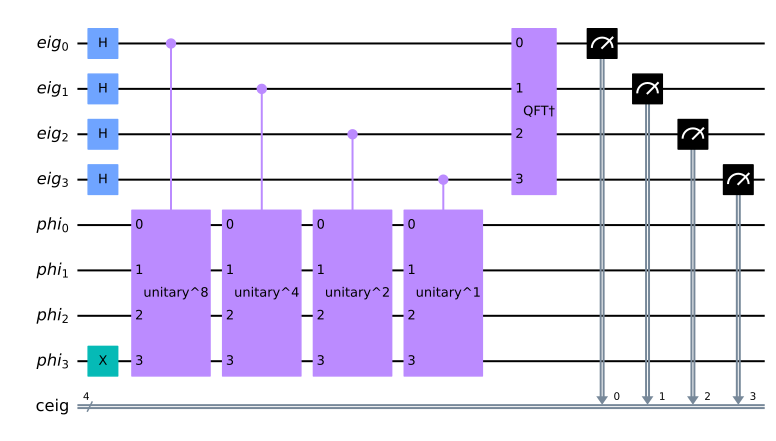

In [71]:
m = int(np.ceil(np.log2(N)))
#Comme on fais pas un oracle swap, on simplifie avec :
t = m#t = 2*m

size_eig = t
size_phi = m

eig = QuantumRegister(size_eig, name="eig")
phi = QuantumRegister(size_phi, name="phi")
ceig = ClassicalRegister(size_eig, name="ceig")
qc = QuantumCircuit(eig,phi,ceig)

qc.x(t+m-1)

#On initialise pas car marche ici et l'autre simulateur n'aime pas la fonction initialize
'''
for i in range(0,size_eig):
    qc.initialize(0,i)

qc.initialize(1,size_eig)

for i in range(size_eig+1,size_eig+size_phi):
    qc.initialize(0,i)
'''

for i in range(0,size_eig):
    qc.h(eig[i])

for i in range(0,size_eig):
    qc.append(gateMult(a,N,size_phi).power(2**(size_eig-i-1)).control(),[i]+ list(range(t,t+m)))

#QFT Inverse : 

#qc.append(QFT(size_eig).inverse(),eig)
qc.append(qft_dagger(t), range(t))

for i in range(0, size_eig):
    qc.measure(eig[i],ceig[i])

qc.draw('mpl',fold=-1)

## Determination avec la phase d'un simulateur

Verification avec le simulateur aer determinant r a partir de la solution la plus probable
et supposant avec a^r mod N

In [72]:
nbShots = 1
if (N <= 15):
    nbShots = 100
elif(N > 15 and N<=35):
    nbShots = 5

In [73]:
aer_sim = Aer.get_backend('aer_simulator')
# Setting memory=True below allows us to see a list of each sequential reading
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=nbShots)
result = aer_sim.run(qobj, memory=True).result()
readings = result.get_memory()
print("Register Reading: " + readings[0])
phase = int(readings[0],2)/(2**m)
print("Corresponding Phase: %f" % phase)
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print("r:",r)

if(phase==0):
    print("erreur, tenter un autre a")
if(r%2 == 1):
    print("ne marche pas dans l'algo pure, mais ok dans celui la")
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print("guesses : ",guesses)

Register Reading: 1111
Corresponding Phase: 0.937500
r: 15
ne marche pas dans l'algo pure, mais ok dans celui la
guesses :  [3, 1]


In [74]:
if (guesses[0] == 1 and guesses[1] == 1):
    print("perdu, pas trouve, go tenter un autre a")
elif(guesses[0] != 1):
    print("trouve : ",N,"=",guesses[0],"*",int(N/guesses[0]))
elif(guesses[1] != 1):
    print("trouve : ",N,"=",guesses[1],"*",int(N/guesses[1]))

trouve :  15 = 3 * 5


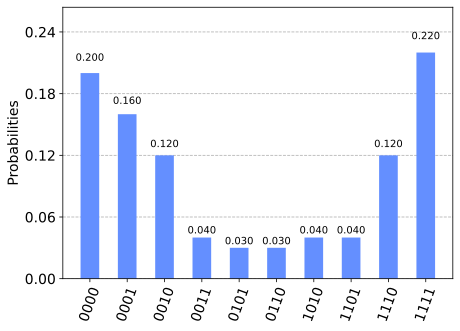

In [75]:
counts = result.get_counts()
plot_histogram(counts)

# Version complete

In [76]:
N = 15
nbShots = 4

In [77]:
def qpe(a,N):
    m = int(np.ceil(np.log2(N)))
    t = m
    size_eig = t
    size_phi = m
    eig = QuantumRegister(size_eig, name="eig")
    phi = QuantumRegister(size_phi, name="phi")
    ceig = ClassicalRegister(size_eig, name="ceig")
    qc = QuantumCircuit(eig,phi,ceig)
    qc.x(t+m-1) # And auxiliary register
    for i in range(0,size_eig):
        qc.h(eig[i])
    for i in range(0,size_eig):
        qc.append(gateMult(a,N,size_phi).power(2**(size_eig-i-1)).control(),[i]+ list(range(t,t+m)))
    qc.append(qft_dagger(t), range(t))
    for i in range(0, size_eig):
        qc.measure(eig[i],ceig[i])
    
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=nbShots)
    result = aer_sim.run(qobj, memory=True).result()
    readings = result.get_memory()
    phase = int(readings[0],2)/(2**m)
    return phase

In [82]:
old_a = []
factor_found = False
attempt = 0
while (not factor_found and (len(old_a) < (N-2))):
    a = randint(2,N)
    while a in old_a:
        if (k != 1):
            P = k
            Q = N // gcd(a, N)
            print("Cout de chance, Facteur trivial trouve pour a=",a)
            print(f"{P} x {Q} = {N}")
            break
        a = randint(0,N)
    old_a.append(a)
    attempt += 1
    print(f"\nEssai {attempt} avec a: {a}")
    try:
        phase = qpe(a,N) # Phase = s/r
    except:#probleme matrice unitaire
        continue
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    if phase != 0:
        if (r%2 == 1):
            print("r impair, Ne marche pas dans l'algo de base mais devrait etre ok ici")
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        if ((guesses[0] == 1 and guesses[1] == 1) or (N in guesses)):
            print("perdu, pas trouve, go tenter un autre a")
        elif(guesses[0] != 1):
            print("trouve : ",N,"=",guesses[0],"*",int(N/guesses[0])," avec r :",r)
            factor_found = True
        elif(guesses[1] != 1):
            print("trouve : ",N,"=",guesses[1],"*",int(N/guesses[1])," avec r :",r)
            factor_found = True


Essai 1 avec a: 13
r impair, Ne marche pas dans l'algo de base mais devrait etre ok ici
trouve :  15 = 3 * 5  avec r : 11
